In [45]:
#  Import relevant libraries

import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [46]:
#  Check collected data

# Define your database connection parameters
db_username = 'postgres'
db_password = 'postgres'
db_host = 'localhost'
db_port = '5432'
db_name = 'Group 4 Project Statistics'
db_table = 'original_data'

# Create the connection string
connection_string = f'postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}'

# Create the SQLAlchemy engine
engine = create_engine(connection_string)

# Query the data from your table
query = f'SELECT * FROM {db_table}'

# Read the data into a pandas DataFrame
data = pd.read_sql(query, engine)

# Close the connection
engine.dispose()

# Display the DataFrame
display(data.head())
print("Original data types:")
print(data.dtypes)

,season_end,team,average_distance_to_away_games,squad_value,net_summer_transfer_spend,retained_manager,average_attendance,wage_bill,retained_captain,previous_season_disciplinary_points,net_number_of_transfers,previous_season_goal_difference,previous_season_position,position_bin
0,2019,Arsenal,371,580750000,71050000,False,59989,135360000,False,67,0,23,6,2
1,2020,Arsenal,163,604250000,107150000,True,60279,118540000,False,79,-3,22,5,1
2,2021,Arsenal,173,540800000,57140000,True,10000,147450000,True,108,5,8,8,1
3,2022,Arsenal,162,521000000,116250000,True,59763,114370000,False,68,4,16,8,2
4,2023,Arsenal,153,935000000,144080000,True,60186,101660000,False,72,1,13,5,2


Original data types:
season_end                             object
team                                   object
average_distance_to_away_games          int64
squad_value                             int64
net_summer_transfer_spend               int64
retained_manager                         bool
average_attendance                      int64
wage_bill                               int64
retained_captain                         bool
previous_season_disciplinary_points     int64
net_number_of_transfers                 int64
previous_season_goal_difference         int64
previous_season_position                int64
position_bin                            int64
dtype: object


In [47]:
#  Preprocessing

# Function to identify problematic columns
def identify_mixed_type_columns(df):
    mixed_type_columns = []
    for column in df.columns:
        if df[column].dtype == 'object':
            try:
                pd.to_numeric(df[column])
            except ValueError:
                if df[column].str.contains(',').any():  # Check if any cell contains a comma
                    mixed_type_columns.append(column)
    return mixed_type_columns

# Identify problematic columns
problematic_columns = identify_mixed_type_columns(data)
print("Problematic columns:", problematic_columns)

# Handle problematic columns
for column in problematic_columns:
    data[column] = data[column].str.replace(',', '')  # Remove commas
    data[column] = pd.to_numeric(data[column], errors='coerce')  # Convert to numeric, invalid parsing will be set as NaN

# Identify numeric and categorical columns
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Remove 'Position Bin' from features if it's present
if 'Position Bin' in numeric_features:
    numeric_features.remove('Position Bin')
if 'Position Bin' in categorical_features:
    categorical_features.remove('Position Bin')

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Problematic columns: []
Numeric features: ['average_distance_to_away_games', 'squad_value', 'net_summer_transfer_spend', 'average_attendance', 'wage_bill', 'previous_season_disciplinary_points', 'net_number_of_transfers', 'previous_season_goal_difference', 'previous_season_position', 'position_bin']
Categorical features: ['season_end', 'team']


In [48]:
# Prepare the features and target

X = data.drop('position_bin', axis=1)
y = data['position_bin']

In [49]:
# Encode target variable

le = LabelEncoder()
y = le.fit_transform(y)

In [50]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
print("Columns in X_train:", X_train.columns)
print("Columns in X_test:", X_test.columns)

Columns in X_train: Index(['season_end', 'team', 'average_distance_to_away_games', 'squad_value',
       'net_summer_transfer_spend', 'retained_manager', 'average_attendance',
       'wage_bill', 'retained_captain', 'previous_season_disciplinary_points',
       'net_number_of_transfers', 'previous_season_goal_difference',
       'previous_season_position'],
      dtype='object')
Columns in X_test: Index(['season_end', 'team', 'average_distance_to_away_games', 'squad_value',
       'net_summer_transfer_spend', 'retained_manager', 'average_attendance',
       'wage_bill', 'retained_captain', 'previous_season_disciplinary_points',
       'net_number_of_transfers', 'previous_season_goal_difference',
       'previous_season_position'],
      dtype='object')


In [52]:
print("Actual columns in X_train:", X_train.columns.tolist())
print("Actual columns in X_test:", X_test.columns.tolist())

Actual columns in X_train: ['season_end', 'team', 'average_distance_to_away_games', 'squad_value', 'net_summer_transfer_spend', 'retained_manager', 'average_attendance', 'wage_bill', 'retained_captain', 'previous_season_disciplinary_points', 'net_number_of_transfers', 'previous_season_goal_difference', 'previous_season_position']
Actual columns in X_test: ['season_end', 'team', 'average_distance_to_away_games', 'squad_value', 'net_summer_transfer_spend', 'retained_manager', 'average_attendance', 'wage_bill', 'retained_captain', 'previous_season_disciplinary_points', 'net_number_of_transfers', 'previous_season_goal_difference', 'previous_season_position']


In [53]:
print("Numeric features used in preprocessor:", numeric_features)
print("Categorical features used in preprocessor:", categorical_features)

Numeric features used in preprocessor: ['average_distance_to_away_games', 'squad_value', 'net_summer_transfer_spend', 'average_attendance', 'wage_bill', 'previous_season_disciplinary_points', 'net_number_of_transfers', 'previous_season_goal_difference', 'previous_season_position', 'position_bin']
Categorical features used in preprocessor: ['season_end', 'team']


In [54]:
# Update feature lists based on actual columns
numeric_features = [col for col in numeric_features if col in X_train.columns]
categorical_features = [col for col in categorical_features if col in X_train.columns]

print("Updated numeric features:", numeric_features)
print("Updated categorical features:", categorical_features)

Updated numeric features: ['average_distance_to_away_games', 'squad_value', 'net_summer_transfer_spend', 'average_attendance', 'wage_bill', 'previous_season_disciplinary_points', 'net_number_of_transfers', 'previous_season_goal_difference', 'previous_season_position']
Updated categorical features: ['season_end', 'team']


In [55]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [56]:
# Fit the preprocessor on the training data and transform both training and test data

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

C:\Users\alee\AppData\Local\anaconda3\envs\dev\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [57]:
# Get feature names after preprocessing

onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features).tolist()
feature_names = numeric_features + cat_feature_names

In [58]:
# Convert to DataFrames

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names)

In [59]:
print("Preprocessing complete. Ready for model training.")
print(f"Training set shape: {X_train_preprocessed.shape}")
print(f"Testing set shape: {X_test_preprocessed.shape}")

Preprocessing complete. Ready for model training.
Training set shape: (192, 41)
Testing set shape: (48, 41)


In [60]:
# Display sample of preprocessed features to verify

display("\nSample of preprocessed features (training set):")
display(X_train_preprocessed.head())

'\nSample of preprocessed features (training set):'

,average_distance_to_away_games,squad_value,net_summer_transfer_spend,average_attendance,wage_bill,previous_season_disciplinary_points,net_number_of_transfers,previous_season_goal_difference,previous_season_position,season_end_2020,...,team_Newcastle,team_Norwich City,team_Nottingham Forest,team_Sheffield United,team_Southampton,team_Tottenham,team_Watford,team_West Bromwich,team_West Ham,team_Wolverhampton
0,-0.751913,-0.603814,0.251490,-0.093316,-0.968501,0.714835,1.237803,1.249251,-1.456823,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.088238,-0.031986,-0.768745,-0.049998,-0.103165,-0.775644,-0.321634,-0.159389,-0.216031,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.109919,-0.368859,-1.128092,-0.070722,-0.943764,0.714835,-0.633521,-0.335469,-0.038775,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.646812,-0.737180,0.075131,-0.432381,-0.224457,-0.651438,-0.945408,-1.145437,0.847506,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.320122,-0.351407,-0.720921,0.321670,0.022330,1.770590,0.614028,-1.075005,1.202018,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Print feature names after preprocessing

print("\nFeature names after preprocessing:")
print(X_train_preprocessed.columns.tolist())


Feature names after preprocessing:
['average_distance_to_away_games', 'squad_value', 'net_summer_transfer_spend', 'average_attendance', 'wage_bill', 'previous_season_disciplinary_points', 'net_number_of_transfers', 'previous_season_goal_difference', 'previous_season_position', 'season_end_2020', 'season_end_2021', 'season_end_2022', 'season_end_2023', 'season_end_2024', 'team_Aston Villa', 'team_Bournemouth', 'team_Brentford', 'team_Brighton', 'team_Burnley', 'team_Cardiff', 'team_Chelsea', 'team_Crystal Palace', 'team_Everton', 'team_Fulham', 'team_Huddersfield', 'team_Leeds', 'team_Leicester', 'team_Liverpool', 'team_Luton', 'team_Manchester City', 'team_Manchester United', 'team_Newcastle', 'team_Norwich City', 'team_Nottingham Forest', 'team_Sheffield United', 'team_Southampton', 'team_Tottenham', 'team_Watford', 'team_West Bromwich', 'team_West Ham', 'team_Wolverhampton']


In [62]:
# Train a RandomForest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_preprocessed, y_train)

RandomForestClassifier(random_state=42)

In [63]:
# Make predictions

y_pred = rf.predict(X_test_preprocessed)

In [64]:
# Evaluate the model

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.47      0.47        15
           1       0.29      0.27      0.28        15
           2       0.53      0.56      0.54        18

    accuracy                           0.44        48
   macro avg       0.43      0.43      0.43        48
weighted avg       0.43      0.44      0.43        48


Confusion Matrix:
[[ 7  4  4]
 [ 6  4  5]
 [ 2  6 10]]


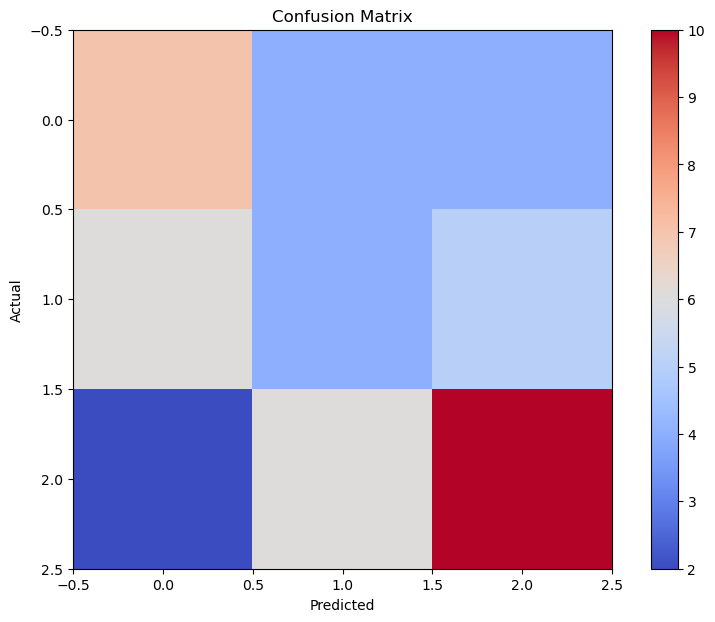

In [65]:
# Visualize the confusion matrix

plt.figure(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Top 10 Most Important Features:
   Importance                              Feature
0    0.095508                   average_attendance
1    0.094127      previous_season_goal_difference
2    0.093626                          squad_value
3    0.093309       average_distance_to_away_games
4    0.089826             previous_season_position
5    0.086913                            wage_bill
6    0.086910  previous_season_disciplinary_points
7    0.086318            net_summer_transfer_spend
8    0.072146              net_number_of_transfers
9    0.026436                      season_end_2022


<Figure size 1000x600 with 0 Axes>

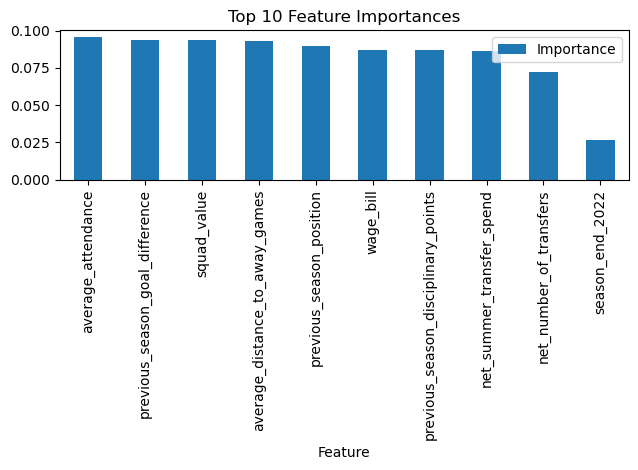

In [66]:
# Get feature importances

importances = rf.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(importances, X_train_preprocessed.columns), reverse=True), 
                           columns=['Importance', 'Feature'])

# Display top 10 most important features

print("\nTop 10 Most Important Features:")
print(feature_imp.head(10))

# Visualize feature importances

plt.figure(figsize=(10, 6))
feature_imp.head(10).plot(x='Feature', y='Importance', kind='bar')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()